# "Part 2 - Featurising HN items for HackerMark"
> "Taking a word2vec approach, I featurised each HN item's title."

- toc: true
- branch: master
- badges: true
- comments: true
- author: Pushkar Paranjpe
- categories: [HN, google, chrome, extension, unsupervised, ML]

### Load saved HN items data

In [7]:
import pickle


with open('data/hn.stories.dt.pickle', 'rb') as inpf:
    df_stories = pickle.load(inpf)

print(df_stories.shape)
display(df_stories.head())

(3683879, 3)


,title,id,timestamp
0,"Is $100,000 middle class in America?",15559979,2017-10-26 15:49:32+00:00
1,The End of Xeon Phi – It’s Xeon and Maybe GPUs...,17637302,2018-07-29 09:54:26+00:00
2,Apple Store App knows when you walk into an Ap...,3139391,2011-10-21 12:10:19+00:00
3,The Difference in Work for Beginner and Profes...,19918406,2019-05-15 11:42:08+00:00
4,Jump2header: Add markdown links to the top of ...,22789110,2020-04-05 22:02:34+00:00


### Pre-processing the stories

In [5]:
import re


def clean_text(text):
    # Drop quotes, commas and dots
    text = re.sub('[\'\"\.,]', '', text)
    # Replace all symbols (except: $, ?, !) with whitespace
    text = re.sub('[^a-zA-Z0-9$\?\!]', ' ', text)
    # Lower case
    text = text.lower()
    # Replace digits with <NUM>
    text = re.sub('\d+', ' <NUM> ', text)
    # Pad title with <START> and <END> tokens
    text = '<START> ' + text + ' <END>'
    return text


# Drop stories that are without titles
df_stories = df_stories[~df_stories['title'].isna()]

# Apply the pre-processing function
df_stories['title-proc'] = df_stories['title'].apply(clean_text)

print(df_stories.shape)
display(df_stories.head())

(3500863, 4)


,title,id,timestamp,title-proc
0,"Is $100,000 middle class in America?",15559979,2017-10-26 15:49:32+00:00,<START> is $ <NUM> middle class in america? <...
1,The End of Xeon Phi – It’s Xeon and Maybe GPUs...,17637302,2018-07-29 09:54:26+00:00,<START> the end of xeon phi it s xeon and ma...
2,Apple Store App knows when you walk into an Ap...,3139391,2011-10-21 12:10:19+00:00,<START> apple store app knows when you walk in...
3,The Difference in Work for Beginner and Profes...,19918406,2019-05-15 11:42:08+00:00,<START> the difference in work for beginner an...
4,Jump2header: Add markdown links to the top of ...,22789110,2020-04-05 22:02:34+00:00,<START> jump <NUM> header add markdown links ...


### Prepare data for Gensim's word2vec module

In [6]:
from nltk.tokenize import WhitespaceTokenizer


tokenizer = WhitespaceTokenizer()

n = 10 # For dev
# n = df_stories.shape[0]  # Actual training

docs_tokenized = [
    tokenizer.tokenize(row['title-proc'])
    for i, row in df_stories[:n].iterrows()
]

print('Tokenized {} docs'.format(len(docs_tokenized)))

Tokenized 10 docs


#### Checkpoint - tokenised data, ready for Gensim's word2vec

```python
# Save
with open('data/docs.pickle', 'wb') as outpf:
    pickle.dump(docs_tokenized, outpf)

# Load
with open('data/docs.pickle', 'rb') as inpf:
    docs_tokenized = pickle.load(inpf)
```

Saving data at intermediate steps is a good practice when developing ML models. Pick-up from where you left and don't wait the boring wait. Leaves you more time for building out the rest of the pipeline.

### Train the word2vec model

In [11]:
from gensim.models.word2vec import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec


# Hyperparameters
EMB_DIM = 64
ITERS_COUNT = 5 # Dev value; I had used '50' for actual training
WINDOW_LEN = 4
WORD_COUNT_MIN = 1

# A utility class to print loss after every epoch
class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        print('Loss after epoch {}: {}'.format(self.epoch, loss))
        self.epoch += 1


model = Word2Vec(
    docs_tokenized,
    iter=ITERS_COUNT,
    size=EMB_DIM,
    window=WINDOW_LEN,
    min_count=WORD_COUNT_MIN,
    workers=4,
    compute_loss=True,
    callbacks=[callback()]
)

print(model)

Loss after epoch 0: 144.2177734375
Loss after epoch 1: 313.227783203125
Loss after epoch 2: 461.83636474609375
Loss after epoch 3: 563.6613159179688
Loss after epoch 4: 715.7371215820312
Word2Vec(vocab=68, size=64, alpha=0.025)


Why does the "loss" seem to increase after every epoch ?! Well - gensim devs decided to compute the cumulative loss across epochs. If you want loss value specific to each epoch - just output a diff() of this series.

#### Checkpoint - trained word2vec model

```python
import gensim.models


# Save
model.wv.save_word2vec_format('data/w2v.model')

# Load
model = gensim.models.KeyedVectors.load_word2vec_format("data/w2v.model", binary=False)
```


### Featurise each HN item

In [19]:
import numpy as np


# Utility function that vectorises a single document
def d2v(idx, doc):
    return np.hstack(([idx], np.mean(model[doc], axis=0)))


```python
import dask


# Use a dask wrapper to parallelise the task of vectorising all documents
d_d2v = dask.delayed(d2v)

n = len(docs_tokenized)//10  # For dev - work on 1/10th of total number of docs
# n = len(docs_tokenized)//1  # Actual training

# We will break-up the total vectorisation work into chunks so that we don't run out of memory
chunks = list(range(0, n, n//10)) + [n]

for k, _ in enumerate(chunks[:-1]):
    print('Preparing lazy tasks...')
    chunk_start = chunks[k]
    chunk_end = chunks[k+1]
    print([chunk_start, chunk_end])
    tasks = (
        d_d2v(idx, doc)
        for idx, doc in enumerate(docs_tokenized[chunk_start:chunk_end])
    )
    print('Computing tasks...')
    results = dask.compute(*tasks)
    with open('data/vecs_{:08d}_{:08d}'.format(chunk_start, chunk_end), 'wb') as outpf:
        pickle.dump(results, outpf)
        print(outpf)
    print('Done.')
```

This will create bunch of pickle files - one for each chunk.
Now, let's load each pickle and combine them all into one single numpy ndarray.

```python
vecs = None
for k, _ in enumerate(chunks[:-1]):
    chunk_start = chunks[k]
    chunk_end = chunks[k+1]
    print([chunk_start, chunk_end])
    with open('data/vecs_{:08d}_{:08d}'.format(chunk_start, chunk_end), 'rb') as inpf:
        vecs = np.vstack([vecs, *pickle.load(inpf)]) if type(vecs) == np.ndarray else np.vstack(pickle.load(inpf))
        print(vecs.shape)

# Save the vectors
with open('data/vecs.pickle', 'wb') as outpf:
    pickle.dump(vecs, outpf)
    
# Create and save the doc index
idx_to_doc = {
    idx: doc
    for idx, doc in enumerate(docs_tokenized)
}
with open('data/idx_to_doc.pickle', 'wb') as outpf:
    pickle.dump(idx_to_doc, outpf)
    
```

### Load trained vectors and doc index

Here I will simply load my "pre-trained" vectors and the document index.

In [22]:
import gensim.models


# Load model
model = gensim.models.KeyedVectors.load_word2vec_format("data/w2v.model", binary=False)

# Load vectors
with open('data/vecs.pickle', 'rb') as inpf:
    vecs = pickle.load(inpf)
print(vecs.shape)

# Load doc index
with open('data/idx_to_doc.pickle', 'rb') as inpf:
    idx_to_doc = pickle.load(inpf)
print(len(idx_to_doc), 'docs')


(3500863, 64)
3500863 docs


### Let's explore the trained vectors a bit

In [23]:
import numpy as np
import sklearn.metrics


def get_nn_by_idx(idx_src, top_k=30):
    print(df_stories['title'][idx_src])
    sims = sklearn.metrics.pairwise.cosine_similarity(
        vecs[idx_src].reshape(1, -1),
        vecs
    )
    sims = sims.reshape(-1)
    ranker = np.argsort(-sims)
    ranked_tpl = tuple(zip(df_stories['title'][ranker[:top_k]], sims[ranker[:top_k]]))
    return ranked_tpl


idx_src = 17300
get_nn_by_idx(idx_src)

Elon Musk: The mind behind Tesla, SpaceX, SolarCity


(('Elon Musk: The mind behind Tesla, SpaceX, SolarCity', 1.0000000000000002),
 ('TED: Elon Musk: The mind behind Tesla, SpaceX, SolarCity',
  0.9901475391454364),
 ('Elon Musk at TED: The mind behind Tesla, SpaceX, SolarCity ...',
  0.9762480544658949),
 ('Elon Musk: The mind behind Tesla, SpaceX, SolarCity ... (TED interview video)',
  0.9570489372431716),
 ('Elon Musk / Tesla Harpooned Baseload Power', 0.9455763232082026),
 ("Tesla Motors' history, according to Elon Musk", 0.9409129143294029),
 ("Watch Tesla and SpaceX CEO Elon Musk 'Wing It'", 0.9301289785801119),
 ("Tesla and SpaceX: Elon Musk's industrial empire [video]",
  0.9295719274744014),
 ('Elon Musk Left OpenAI to Focus on Tesla, SpaceX', 0.9259167457747793),
 ('Tesla’s Elon Musk Hints at His Next Big Project: Electric Airplanes',
  0.9253731125946242),
 ('Elon Musk reveals SpaceX spacesuit', 0.9231230178852836),
 ("Tesla: Elon Musk reveals latest 'masterplan'", 0.9206816496333221),
 ('Elon Musk: Predictions for Tesla', 0.

So our input doc (@idx 17300) had the title "Elon Musk: The mind behind Tesla, SpaceX, SolarCity". The nearest neighbor docs that our model returned - are also about Elon Musk.  
OK. Looks like we are getting sensible output.  
Let's do more try-outs !

In [42]:
get_nn_by_idx(42, top_k=5)

SEO ΕΝΤΟΣ ΣΕΛΙΔΑΣ – SEO – WEB DESIGN


(('Αποτυχημένα Πειράματα SEO – SEO | WEB DESIGN', 1.0000000000000002),
 ('Η+καμπύλη+μάθησης+στο+SEO+-+SEO+|+WEB+DESIGN', 1.0000000000000002),
 ('SEO ΕΝΤΟΣ ΣΕΛΙΔΑΣ – SEO – WEB DESIGN', 1.0000000000000002),
 ('SEO+ΕΝΤΟΣ+ΣΕΛΙΔΑΣ+-+SEO+|+WEB+DESIGN', 1.0000000000000002),
 ('Πόσο σημαντικό είναι το SEO στην κατασκευή ιστοσελίδων; – SEO – WEB DESIGN',
  1.0000000000000002))

In [43]:
get_nn_by_idx(1000, top_k=5)

What are the hidden cost of cloud computing?


(('What are the hidden cost of cloud computing?', 1.0000000000000004),
 ('What are the Dangers of Cloud Computing?', 0.9697405649995038),
 ('What are the new realities of the Cloud marketplace?', 0.948241031437423),
 ('What are the main issues/shortcomings of cloud computing?',
  0.9460991754426975),
 ('What are the risks of cloud services?', 0.9428724582755382))

In [45]:
get_nn_by_idx(5555, top_k=5)  # Not so good :( 

Limited Progress Seen Even as More Nations Step Up on Climate


(('Limited Progress Seen Even as More Nations Step Up on Climate',
  1.0000000000000002),
 ('EU on verge of overtaking US as the better place for entrepreneurs to reside',
  0.8813214417831587),
 ('The new coronavirus appears to take a greater toll on men than on women',
  0.8766103721701922),
 ('The Unexpected Step That Led Us to Transparent Salaries',
  0.8754170062642075),
 ('California wildfires sped up climate change as much as a whole year of power use',
  0.8733405020767046))

In [46]:
get_nn_by_idx(100001, top_k=5)

What to Expect in the New Microsoft Edge Insider Channels


(('What to Expect in the New Microsoft Edge Insider Channels',
  1.0000000000000002),
 ('Microsoft in 2013: what to expect', 0.939729428839874),
 ('The Google Shift In Enterprise IT', 0.9307101135113099),
 ('Upgrading to the New Microsoft Edge', 0.9286608938088898),
 ('What’s new in Microsoft Edge', 0.9270582052153575))

In [47]:
get_nn_by_idx(88888, top_k=5)  # Not so good :(

The Technology Behind the U.S. Open


(('The Technology Behind the U.S. Open', 1.0),
 ('The Alchemy of the U.S. Open Schedule ', 0.9385653094871506),
 ('The Innovation Behind the Technology', 0.9266781727797966),
 ('The Future of the Open Internet', 0.9261051564185586),
 ('The Open Office and the Spirit of Capitalism', 0.9246536131256814))

Sometimes the "nearest" documents returned by our model are not so good. This could be largely due to imbalance in the representation across different topics or perhaps can be improved by tuning the model further.  
But overall, the nereast neighbor lookups are yielding sensible results.

In [27]:
def get_nn_by_text(text, top_k=30):
    print(text)
    doc = tokenizer.tokenize(clean_text(text))
    sims = sklearn.metrics.pairwise.cosine_similarity(
        d2v(0, doc).reshape(1, -1)[:, 1:],
        vecs
    )
    sims = sims.reshape(-1)
    ranker = np.argsort(-sims)
    ranked_tpl = tuple(zip(df_stories['title'][ranker[:top_k]], sims[ranker[:top_k]]))
    return ranked_tpl


text = 'Python dev tools'
get_nn_by_text(text)

Python dev tools


(('Java Dev Tools', 0.9672161434264985),
 ('Tools for Python Developers', 0.9521089622128531),
 ('Python debugging tools', 0.9447605911498455),
 ('Developer Tools in Python', 0.9444010461622591),
 ('Python tools', 0.9425476909117002),
 ('12 PHP Debugging Tools for Developers', 0.9297497162130086),
 ('Useful Tools for Python Developers', 0.9271513779246525),
 ('Useful Tools for Python Developers', 0.9271513779246525),
 ('Useful Tools for Python Developers', 0.9271513779246525),
 ('Ruby development tools for Emacs and Vim', 0.9227354537698468),
 ('JavaScript development tools – resources', 0.9213798799546349),
 ('Javascript development tools - resources', 0.9213798799546349),
 ('Top Visual Studio Code Extensions for Python Development',
  0.9203817947689437),
 ("Mozilla's Python tools", 0.9187298567082218),
 ('Development environments for beginners: ruby, javascript, and python',
  0.9140147448260572),
 ('Advanced Git Tips for Python Developers', 0.9138558826895148),
 ('Scala Tools', 0.9

OK. That's not bad either!  
Congratulations - vectors are baked and ready for consumption.

In [28]:
import sklearn.manifold


# Sample size
n_limit = 10000

tsne = sklearn.manifold.TSNE(
    perplexity=30.0,
    early_exaggeration=12.0,
    learning_rate=200.0,
    n_iter=1000,
    metric='euclidean',
    verbose=1
)

X_tsne = tsne.fit_transform(vecs[:n_limit])
print(X_tsne.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.019s...
[t-SNE] Computed neighbors for 10000 samples in 12.908s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.404193
[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.332436
[t-SNE] KL divergence after 1000 iterations: 2.932338
(10000, 2)


#### Checkpoint - 2d tSNE vectors

```python
# Save
with open('data/X_tsne.pickle', 'wb') as otpf:
    pickle.dump(X_tsne, otpf)

# Load
with open('data/X_tsne.pickle', 'rb') as inpf:
    X_tsne = pickle.load(inpf)
```

In [2]:
import pickle


# Load
with open('data/X_tsne.pickle', 'rb') as inpf:
    X_tsne = pickle.load(inpf)

### Visualising trained vectors via tSNE

Let's try to visualise our vectors. There are ~3M of them and that's too many for plotting.
So we will sample some tSNE vectors and visualise them via a scatter plot.

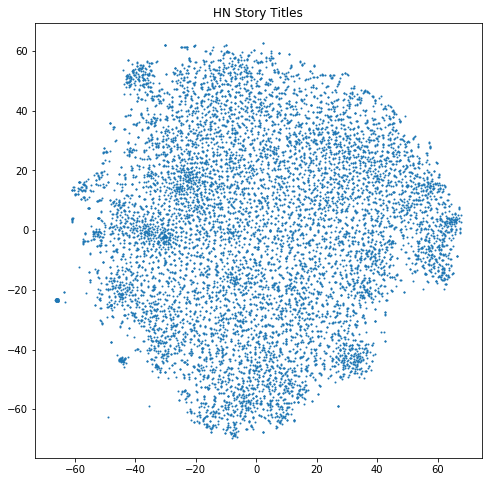

In [10]:
from matplotlib import pyplot as plt


fig, ax = plt.subplots()
ax.scatter(X_tsne[:n_limit, 0], X_tsne[:n_limit, 1], s=1)
plt.title('HN Story Titles')
fig.set_size_inches(8, 8)

Hmmmm. There are some "dense pockets" but there is a lot of "unstructured mass" too. Let's explore these spaces a bit.

In [12]:
import plotly.graph_objects as go


n_limit = 10000


fig = go.Figure(
    data=go.Scatter(
        x=X_tsne[:n_limit, 0],
        y=X_tsne[:n_limit, 1],
        text=df_stories['title'][:n_limit].tolist(),
        mode='markers',
        marker=dict(size=3)
    )
)

fig.update_layout(title='HN Story Titles', height=800, width=800)
fig.show()